**Part 1**

The inverse exponentiated squared Euclidean distance kernel (no extra hyperparameters) was used.

In [46]:
import numpy as np

X = np.array([[0.12, 0.55],
              [0.80, 0.45],
              [0.17, 0.23],
              [0.52, 0.38],
              [0.51, 0.62]])

y = np.array([4.2, 2.2, 2.8, 5.0, 5.5])

X_query = np.array([[0.42, 0.33],
                    [0.95, 0.15]])

def kernel(a, b):
    diff = a[:, None, :] - b[None, :, :]
    d2 = np.sum(diff**2, axis=2)
    return np.exp(-d2)

K = kernel(X, X)                        
K_query = kernel(X, X_query)            
kss = np.diag(kernel(X_query, X_query))

K_inv = np.linalg.inv(K)               

mu_star = K_query.T.dot(K_inv.dot(y))  

var_star = np.zeros(K_query.shape[1])
for j in range(K_query.shape[1]):
    kx = K_query[:, j]                 
    var_star[j] = kss[j] - kx.T.dot(K_inv).dot(kx)

for i, x in enumerate(X_query):
    print(f"Point {i+1}: x = [{x[0]:.2f}, {x[1]:.2f}]")
    print(f"  Predictive mean = {mu_star[i]:.6f}")
    print(f"  Predictive variance = {var_star[i]:.6e}\n")

Point 1: x = [0.42, 0.33]
  Predictive mean = 4.977931
  Predictive variance = 1.917638e-04

Point 2: x = [0.95, 0.15]
  Predictive mean = -0.130094
  Predictive variance = 6.392821e-02



**Part 2**

Use scikit-learn's GaussianProcessRegressor to reproduce the Part 1 predictions using the same kernel(no extra hyperparameters).

In [47]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Same training data as Part 1
X = np.array([[0.12, 0.55],
              [0.80, 0.45],
              [0.17, 0.23],
              [0.52, 0.38],
              [0.51, 0.62]])

y = np.array([4.2, 2.2, 2.8, 5.0, 5.5])

X_query = np.array([[0.42, 0.33],
                    [0.95, 0.15]])

# Build an RBF kernel equivalent to exp(-||x-x'||^2) by setting length_scale = 1/sqrt(2)
length_scale = 1.0 / np.sqrt(2.0)
kernel = RBF(length_scale=length_scale, length_scale_bounds='fixed')

gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, optimizer=None, normalize_y=False)

gpr.fit(X, y)

mu, std = gpr.predict(X_query, return_std=True)
var = std**2

# Print results
for i, x in enumerate(X_query):
    print(f"Point {i+1}: x = [{x[0]:.2f}, {x[1]:.2f}]")
    print(f"  Predictive mean = {mu[i]:.6f}")
    print(f"  Predictive variance = {var[i]:.6e}\n")

Point 1: x = [0.42, 0.33]
  Predictive mean = 4.977931
  Predictive variance = 1.917638e-04

Point 2: x = [0.95, 0.15]
  Predictive mean = -0.130094
  Predictive variance = 6.392821e-02



**Part 3**

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def load_data(csv_path):
    df = pd.read_csv(csv_path)
    return df


def plot_maxOD_vs_glucose(df, glucose_col='Final_Glucose_Conc', maxod_col='MaxOD', normalized=None):
    plt.figure(figsize=(8,5))
    if normalized is None:
        plt.scatter(df[glucose_col], df[maxod_col], alpha=0.5, label='Raw')
        plt.ylabel('MaxOD')
    else:
        plt.scatter(df[glucose_col], normalized, alpha=0.5, label='Normalized')
        plt.ylabel('Normalized MaxOD')
    plt.xlabel('Final Glucose Concentration (mM)')
    plt.title('MaxOD vs Glucose Concentration')
    plt.legend()
    plt.tight_layout()
    plt.show()


def train_gp_model(df, mask, row_col='Row', col_col='Col', maxod_col='MaxOD', n_restarts=5, length_scale=5.0, noise_level=0.01):
    X = df.loc[mask, [row_col, col_col]].values
    y = df.loc[mask, maxod_col].values
    # Kernel: RBF + noise
    kernel = RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts, normalize_y=True)
    gp.fit(X, y)
    return gp


def predict_on_plate(gp, rows, cols):
    grid = np.array([[r, c] for r in rows for c in cols])
    mu, std = gp.predict(grid, return_std=True)
    mu_grid = mu.reshape(len(rows), len(cols))
    std_grid = std.reshape(len(rows), len(cols))
    return mu_grid, std_grid


def plot_plate(mu_grid, title, vmin=None, vmax=None):
    plt.figure(figsize=(10,6))
    plt.imshow(mu_grid, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Predicted MaxOD')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def normalize_data(df, rows, cols, B_grid, G_grid, row_col='Row', col_col='Col', maxod_col='MaxOD'):
    row0 = rows[0]
    col0 = cols[0]
    norm = []
    for _, row in df.iterrows():
        r, c = int(row[row_col]), int(row[col_col])
        ri = r - row0
        ci = c - col0
        if ri < 0 or ri >= B_grid.shape[0] or ci < 0 or ci >= B_grid.shape[1]:
            norm.append(np.nan)
            continue
        b = B_grid[ri, ci]
        g = G_grid[ri, ci]
        norm.append((row[maxod_col] - b) / g if g != 0 else np.nan)
    return np.array(norm)

### 1:

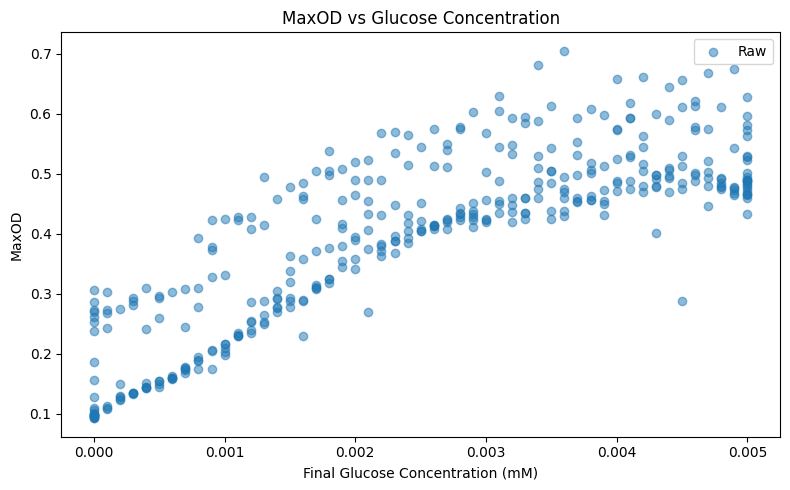

In [49]:
import numpy as np

csv_path = 'GlucoseGrowthData.csv'
df = load_data(csv_path)

glucose_col = 'Final_Glucose_Conc'
maxod_col = 'MaxOD'
row_col = 'Row'
col_col = 'Col'

plot_maxOD_vs_glucose(df, glucose_col=glucose_col, maxod_col=maxod_col)


### 2:

In [50]:
#Train GP for blanks (zero glucose)
blank_mask = df[glucose_col] == 0
B_gp = train_gp_model(df, blank_mask, row_col=row_col, col_col=col_col, maxod_col=maxod_col)

#Train GP for max glucose
max_glu = df[glucose_col].max()
max_mask = df[glucose_col] == max_glu
G_gp = train_gp_model(df, max_mask, row_col=row_col, col_col=col_col, maxod_col=maxod_col)


/home/zchx/miniconda3/envs/CelLink/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zchx/miniconda3/envs/CelLink/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


### 3: Do the blanks or the maximum concentration wells display greater spatial variation? Does this make sense?

**The blank wells (Model B) display greater spatial variation.** The heatmap for the "Predicted Blank MaxOD (B)" shows a distinct, smooth gradient, with higher optical density (OD) in the center of the plate and lower OD toward the edges. In contrast, the "Predicted Max Glucose MaxOD (G)" plot appears much more uniform with less structured variation.

**Yes, this makes sense.** This pattern is a example of "edge effects" in multiwell plates. Wells along the edge can experience different physical conditions, such as temperature gradients or increased evaporation. The baseline microbial growth in the blank wells (with zero glucose) is highly sensitive to these subtle environmental differences. At the maximum glucose concentration, however, growth is likely limited by the abundance of glucose itself or another shared nutrient, making it less sensitive to the minor physical variations across the plate and resulting in a more uniform outcome.


In [51]:
rows = np.arange(df[row_col].min(), df[row_col].max()+1, dtype=int)
cols = np.arange(df[col_col].min(), df[col_col].max()+1, dtype=int)
B_grid, _ = predict_on_plate(B_gp, rows, cols)
G_grid, _ = predict_on_plate(G_gp, rows, cols)

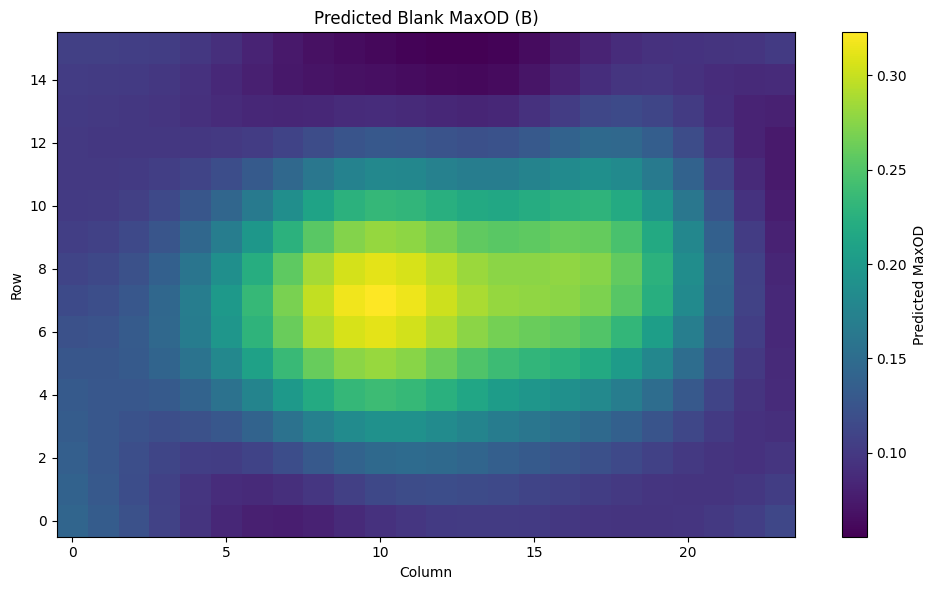

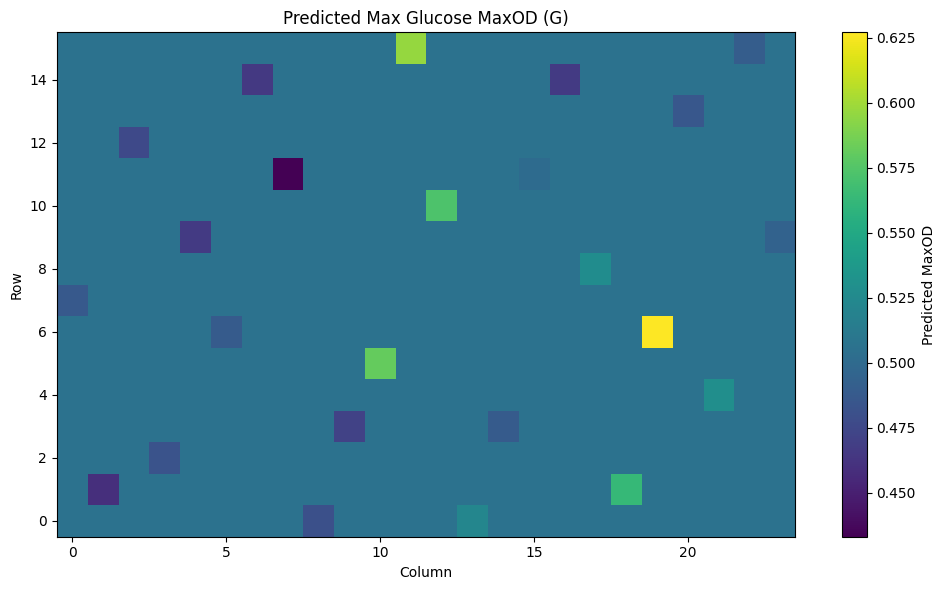

In [52]:
plot_plate(B_grid, 'Predicted Blank MaxOD (B)')
plot_plate(G_grid, 'Predicted Max Glucose MaxOD (G)')


### 4,5: Did you remove the spatial effects?

**Yes, the spatial effects were removed.** The original plot of raw data ("MaxOD vs Glucose Concentration") clearly shows the data points separated into two distinct "curves," an effect the assignment attributes to spatial location.

After applying the normalization, the new plot ("Normalized MaxOD vs Glucose Concentration") shows that these two curves have collapsed into a single, tighter trend. This demonstrates that the normalization procedure has effectively corrected for the spatial variation across the plate.

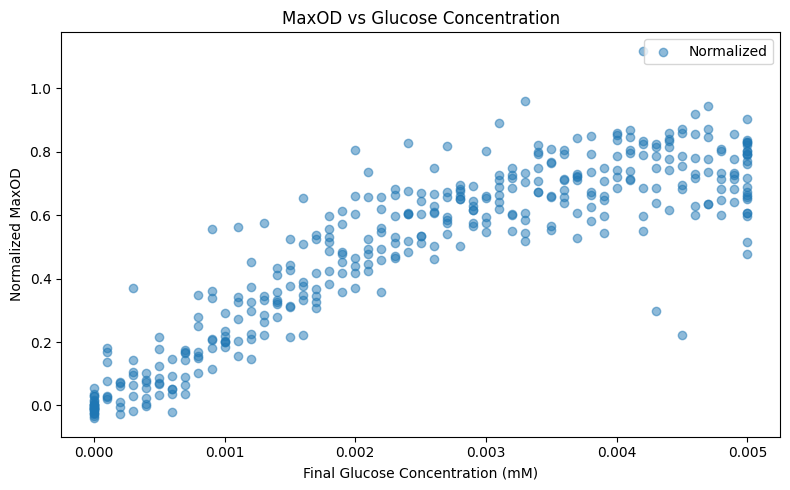

In [53]:
norm = normalize_data(df, rows, cols, B_grid, G_grid, row_col=row_col, col_col=col_col, maxod_col=maxod_col)

plot_maxOD_vs_glucose(df, glucose_col=glucose_col, maxod_col=maxod_col, normalized=norm)